# time dynamics stats

In [28]:
import numpy as np
import pandas as pd
import copy

# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from src.d03_processing.fixations.SignalProcessor import SignalProcessor

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from scipy.linalg import toeplitz
import scipy.stats as stats
from src.d05_modelling.stats import cohensD
from src.d05_modelling.bootline import bootline, participant_ols
from itertools import combinations

In [3]:
df = pd.read_csv('proportion_time_dynamics.csv')
df = df[df.time > 1000].reset_index(drop=True)
df['table_minus_selected'] = df['table'] - df['selected']
df['table_minus_moved'] = df['table'] - df['moved']
df['moved_minus_selected'] = df['moved'] - df['selected']
df['not_moved'] = df['obj2'] + df['obj3'] + df['obj4']
df['table_minus_notmoved'] = df['table'] - df['not_moved']

In [3]:

def cochrane_orcutt(X, y, rho, n_it=100, ax=None, c='m'):
    """
    Implement the Cochrane-Orcutt procedure.
    
    Parameters:
    y -- a numpy array of shape (n, ) (dependent variable)
    X -- a numpy array of shape (n, p) (independent variables)
    
    Returns:
    rho -- the estimated autocorrelation coefficient
    results -- the fitted OLS model
    """
    # Initialize rho at 0
    rho = 0

    # Initialize delta at a value larger than the convergence criterion
    delta = np.inf

    # Loop until convergence
    i=0
    while delta > 1e-4:

        # Transform y and X
        y_star = y[1:] - rho * y[:-1]
        X_star = X[1:] - rho * X[:-1]

        # Fit model
        # print(y_star.shape, X_star.shape)
        model = sm.OLS(y_star, X_star)
        results = model.fit()
        
        if ax is not None:
            ax.plot(X, results.predict(X), f'{c}-', alpha=0.1)

        # Compute residuals
        residuals = results.resid

        # Update rho
        rho_new = np.sum(residuals[:-1] * residuals[1:]) / np.sum(residuals[:-1] ** 2)

        # Compute difference
        delta = np.abs(rho_new - rho)

        # Update rho
        rho_old = rho
        rho = rho_new
        
        # convergence failure
        if i > 90:
            print(rho_old, rho_new, delta)
        if i > n_it:
            print('C-O estimation failed to converge')
            return rho, results
            
        i+=1

    return rho, results


Younger
                             OLS Regression Results                             
Dep. Variable:     table_minus_selected   R-squared:                       0.651
Model:                              OLS   Adj. R-squared:                  0.651
Method:                   Least Squares   F-statistic:                 1.117e+04
Date:                  Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                          16:06:20   Log-Likelihood:                 6815.4
No. Observations:                  5999   AIC:                        -1.363e+04
Df Residuals:                      5997   BIC:                        -1.361e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1448   

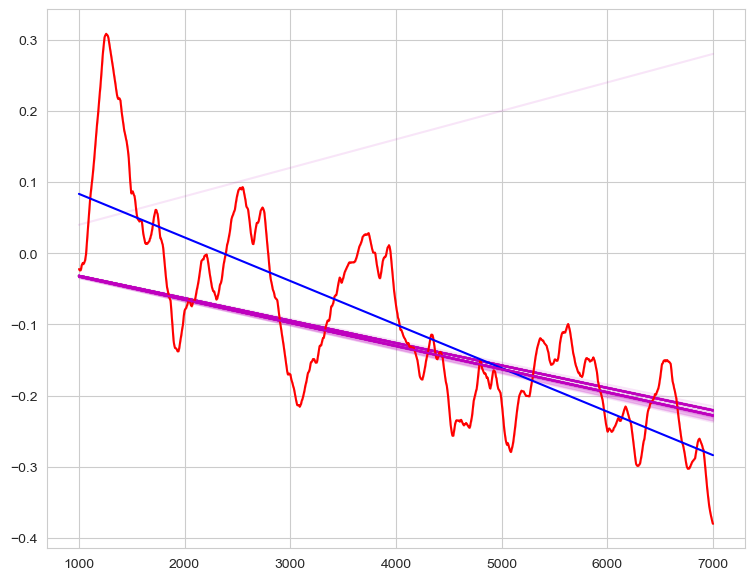

In [4]:
# ax = plt.figure(figsize=(9, 7)).add_subplot()
# sns.scatterplot(x='time', y='table', data=df, hue='group', ax=ax, palette="Set2", alpha=0.1, size=0.1)
# plt.show()
aois_plot= ['moved', 'selected', 'table']
colours = ['r', 'g', 'b', (0, 1, 1), (1, 0, 1)]
colours2 = [(1, 0.5, 0), (0.1, 1, 0.2), (0, 0.5, 1), (0, 0.7, 0.7), (0.7, 0.0, 0.7)]
colours3 = [(1, 0.5, 0), (0.1, 1, 0.2), (0, 0.5, 1), (0, 0.4, 0.4), (0.4, 0.0, 0.4)]
aoi_col = 'table_minus_selected'
aoi_col2 = 'table_minus_moved'
aoi_col3 = 'moved_minus_selected'
ax = plt.figure(figsize=(9, 7)).add_subplot()
# ax2 = plt.figure(figsize=(9, 7)).add_subplot()
g_ind = [4]
p_ind=[i for i in range(1)]
p_ind = [2]
for g, group in enumerate(np.unique(df.group)):
    if g in g_ind:
        print(group)
        df_g = df[df.group == group]
        # sns.regplot(data=df_g, x='time', y=aoi_col, ax=ax, scatter_kws=dict(alpha=0.0, color=colours[g]), line_kws=dict(color=colours[g], alpha=1))
        # sns.regplot(data=df_g, x='time', y=aoi_col2, ax=ax, scatter_kws=dict(alpha=0.0, color=colours2[g]), line_kws=dict(color=colours2[g], alpha=1))
        # sns.regplot(data=df_g, x='time', y=aoi_col3, ax=ax, scatter_kws=dict(alpha=0.0, color=colours3[g]), line_kws=dict(color=colours3[g], alpha=1))
        for p, ppt in enumerate(np.unique(df_g.participant)):
            if p in p_ind:
                df_p = df_g[df_g.participant == ppt].reset_index(drop=True)
                df_p = df_p.dropna().reset_index(drop=True)
                # Run the OLS regression
                model = smf.ols(f'{aoi_col} ~ time', data=df_p)
                ols_res = model.fit()
                print(ols_res.summary())
                # ols_res.plot_diagnostics()
                # Get standard errors of predictions
                ols_fitted = ols_res.predict(df_p.time)
                ols_std = ols_res.get_prediction(df_p.time).se_obs

                # Create upper and lower bounds for standard error space
                lower_ols = ols_fitted - 1.96 * ols_std
                upper_ols = ols_fitted + 1.96 * ols_std

                # Get the residuals from the OLS model
                df_p['residuals'] = ols_res.resid
                df_p = df_p.dropna(subset=['residuals']).drop_duplicates(subset=['residuals']).reset_index(drop=True)
                # print(df_p.head())
                lag = 1
                ar_model = AutoReg(df_p['residuals'], lag, old_names=False)
                ar_res = ar_model.fit()
                print(ar_res.summary())
                rho = ar_res.params[1]
                # print(rho)
                # ar_res.plot_predict()
                # ar_res.plot_diagnostics(lags=30)
                # sel = ar_select_order(df_p['residuals'], lag, old_names=False)
                # sel.ar_lags
                # res = sel.model.fit()
                # print(res.summary())
                
                rho, co_results = cochrane_orcutt(df_p.time.to_numpy(), df_p[aoi_col].to_numpy(), rho, ax=ax)
                print(co_results.summary())
                
                # Fit the model
                ar_model_2 = AutoReg(df_p[aoi_col].to_numpy(), lags=lag, exog=df_p.time.to_numpy(), old_names=False)
                ar2_result = ar_model_2.fit()
                print(ar2_result.summary())
                ar2_fitted = ar2_result.fittedvalues
                ar2_se = ar2_result.bse[2]
                print(ar2_se)
                lower_ar2 = ar2_fitted - 1.96 * ar2_se
                upper_ar2 = ar2_fitted + 1.96 * ar2_se
                ax.plot(df_p.time[lag:], ar2_fitted, 'r-')
                ax.fill_between(df_p.time[lag:], lower_ar2, upper_ar2, color='r', alpha=0.2)


                # ax.plot(df_p.time, df_p[aoi_col], 'b.')
                ax.plot(df_p.time, ols_fitted, 'b-')
                # ax.fill_between(df_p.time, lower_ols, upper_ols, color='b', alpha=0.2)

                # ax.plot(df_p.time, df_p.residuals, 'r.')
                # ax.plot(df_p.time[lag:], ar_res.fittedvalues, 'g-', alpha=0.5,markersize=1)
                
                # Calculate fitted values
                fitted_values = co_results.predict(df_p.time.to_numpy())
                # Get standard errors of predictions
                prediction_std = co_results.get_prediction(df_p.time).se_obs

                # Create upper and lower bounds for standard error space
                lower_bound = fitted_values - 1.96 * prediction_std
                upper_bound = fitted_values + 1.96 * prediction_std

                # Plot fitted values
                ax.plot(df_p.time, fitted_values, 'm-')
                ax.fill_between(df_p.time, lower_bound, upper_bound, color='m', alpha=0.2)
  

                # GET INTERCEPT BY PREDICTING ON 0, OR ON FIRST TIME (E.G. 1000) - DON'T TRY TO ADD TO C-0 ESTIMATION

                # sns.regplot(data=df_p, x='time', y=aoi_col, ax=ax, scatter_kws=dict(alpha=0.01, color=colours[0]), line_kws=dict(color=colours[0], alpha=1))
                # # sns.regplot(data=df_p, x='time', y='ma', ax=ax, scatter_kws=dict(alpha=0.01, color=colours[g]), line_kws=dict(color=colours[g], alpha=1))
                # sns.regplot(data=df_p, x='time', y=aoi_col2, ax=ax, scatter_kws=dict(alpha=0.01, color=colours2[1]), line_kws=dict(color=colours2[1], alpha=1))
                # sns.regplot(data=df_p, x='time', y=aoi_col3, ax=ax, scatter_kws=dict(alpha=0.01, color=colours2[2]), line_kws=dict(color=colours2[2], alpha=1))




# sns.lmplot(x='time', y='table', data=df_1, hue='group', palette="Set2", legend=False, aspect =1.3, scatter_kws=dict(alpha=0.0) )
plt.show()

In [16]:
from scipy.stats import ttest_ind

def get_tstat_clusters(t, group1_mat, group2_mat, t_threshold, alpha=0.05):
    alpha_bonf = 0.05  # / len(t)
    clusters = []
    cluster_ind = 0
    cluster = {'times': [], 'tstats': [], 'cohensD': [], 'pvals': []}
    empty_cluster = copy.deepcopy(cluster)

    all_ts = np.zeros(len(t))
    all_ds = np.zeros(len(t))
    all_ps = np.zeros(len(t))

    for ti in range(len(t)):
        g1 = group1_mat[ti, :]
        g2 = group2_mat[ti, :]
        t_stat, p_val = ttest_ind(g1, g2)
        coh_d = cohensD(g1, g2)

        all_ts[ti] = t_stat
        all_ds[ti] = coh_d
        all_ps[ti] = p_val

        if abs(t_stat) > t_threshold and p_val < alpha_bonf:
            cluster['tstats'].append(t_stat)
            cluster['times'].append(t[ti])
            cluster['cohensD'].append(coh_d)
            cluster['pvals'].append(p_val)
        else:
            if len(cluster['tstats']) > 0:
                clusters.append(cluster)

            cluster = copy.deepcopy(empty_cluster)

            cluster_ind += 1
    if len(cluster['tstats']) > 0:
        clusters.append(cluster)


    return {'clusters': clusters, 'all_tstats': all_ts, 'all_ds': all_ds, 'all_ps': all_ps}

def slope_tstats(group_slopes):
    pass

def get_pairwise_stats(boot_out, groups, alpha_level=0.05):

    t_threshold = stats.t.ppf(1 - alpha_level/2, df=(B_outer*2) - 2)  # pick threshold t based on alpha level two-tailed

    cluster_list = []
    t = boot_out['x']

    group_pairs = list(combinations(groups, 2))
    cluster_pairs = [None]*len(group_pairs)
    cluster_tsums_pairs = [None]*len(group_pairs)
    cluster_dsums_pairs = [None]*len(group_pairs)
    tp_ts = None   # will become array that saves t-stats for each time-point pairwise comparison
    tp_ds = None   # same as above but for cohen's d
    slope_ts = []  # for saving slope per pairwise comparison
    slope_ds = []
    auc_ts = []
    auc_ds = []


    for p in range(len(group_pairs)):
        pair = group_pairs[p]
        matrix1 = boot_out['group_mats'][groups.index(pair[0])]
        matrix2 = boot_out['group_mats'][groups.index(pair[1])]
        clust_out = get_tstat_clusters(t, matrix1, matrix2, t_threshold)
        clusters = clust_out["clusters"]
        cluster_tsums = np.zeros(len(clusters))
        cluster_dsums = np.zeros(len(clusters))
        for i in range(len(clusters)):
            cluster_tsums[i] = np.sum(clusters[i]['tstats'])
            cluster_dsums[i] = np.sum(clusters[i]['cohensD'])


        cluster_pairs[p] = clusters
        cluster_tsums_pairs[p] = cluster_tsums
        cluster_dsums_pairs[p] = cluster_dsums
        tp_ts = clust_out['all_tstats'] if tp_ts is None else np.concatenate([tp_ts, clust_out['all_tstats']])
        tp_ds = clust_out['all_ds'] if tp_ds is None else np.concatenate([tp_ds, clust_out['all_ds']])

        slopes1 = boot_out['group_slopes'][groups.index(pair[0])]
        slopes2 = boot_out['group_slopes'][groups.index(pair[1])]
        auc1 = boot_out['group_auc'][groups.index(pair[0])]
        auc2 = boot_out['group_auc'][groups.index(pair[1])]

        slope_tstat, slope_p_val = ttest_ind(slopes1, slopes2)
        slope_ts.append(slope_tstat)
        slope_ds.append(cohensD(slopes1, slopes2))

        auc_tstat, auc_pval = ttest_ind(auc1, auc2)
        auc_ts.append(auc_tstat)
        auc_ds.append(cohensD(auc1, auc2))


    return {'pairs': group_pairs,
            'pairwise_clusters': cluster_pairs,
            'pairwise_cluster_sums': {'tstats': cluster_tsums_pairs, 'cohensD': cluster_dsums_pairs},
            'tp_stats': np.column_stack([np.array(tp_ts), np.array(tp_ds)]), 'slope_stats': np.column_stack([slope_ts, slope_ds]),
            'auc_stats': np.column_stack([auc_ts, auc_ds])}


In [5]:
def shuffle_groups(df, groups):
    pd.options.mode.chained_assignment = None  # default='warn'
    np.random.seed(None)

    # filter by groups
    df = df[np.isin(df.group, groups)]

    # Find the size of the current groups
    group_sizes = df.groupby('group')['participant'].nunique()

    # Create a unique identifier for each "group-participant" pair
    df['group_participant'] = df['group'] + df['participant'].astype(str)

    # Get a list of unique group_participants
    group_participants = df['group_participant'].unique()

    # Randomly shuffle the group_participants
    np.random.shuffle(group_participants)

    # Assign the group_participants to new groups based on the sizes of the current groups
    new_groups = np.repeat(group_sizes.index, group_sizes)

    # Create a mapping of group_participants to new groups
    mapping = dict(zip(group_participants, new_groups))

    # Create a new column in the DataFrame with the shuffled groups
    df['new_group'] = df['group_participant'].map(mapping)

    # replace group with new group

    df['group'] = df['new_group']

    # # You may now drop the 'group_participant' column if it's no longer needed
    # df.drop('group_participant', axis=1, inplace=True)

    return df

In [21]:
aoi_col = 'table_minus_selected'
aoi_col = 'table_minus_moved'
# aoi_col = 'not_moved'

aoi_cols = ['moved', 'table', 'selected', 'not_moved',
            'table_minus_moved', 'table_minus_selected', 'table_minus_notmoved', 'moved_minus_selected']
B_outer = 50 # number of repetitions for resampling group models
B_middle = 5 # number of repetitions for resampling random participant parameters in boot_ols_boot
B_inner = 5  # bootstrap repetitions for resampling data within each participant for 'boot' ws_method

ws_method = 'rnorm'  # 'boot', 'none'; default='rnorm'
# ws_method = 'none'
groups = ('Younger', 'Older', 'MCI+', 'MCI-')
group_colours = [(0, 0.6, 0), (0, 0, 0.8), (0.8, 0, 0),  (0.7, 0, 0.7)]
boot_results = bootline('time', aoi_col, df=df, groups=groups,
                        ws_method=ws_method, B_outer=B_outer)
pairwise_stats_results = get_pairwise_stats(boot_results, groups)

##### Younger group 0 of 4 #####
Outer loop 0 of 50
Outer loop 1 of 50
Outer loop 2 of 50
Outer loop 3 of 50
Outer loop 4 of 50
Outer loop 5 of 50
Outer loop 6 of 50
Outer loop 7 of 50
Outer loop 8 of 50
Outer loop 9 of 50
Outer loop 10 of 50
Outer loop 11 of 50
Outer loop 12 of 50
Outer loop 13 of 50
Outer loop 14 of 50
Outer loop 15 of 50
Outer loop 16 of 50
Outer loop 17 of 50
Outer loop 18 of 50
Outer loop 19 of 50
Outer loop 20 of 50
Outer loop 21 of 50
Outer loop 22 of 50
Outer loop 23 of 50
Outer loop 24 of 50
Outer loop 25 of 50
Outer loop 26 of 50
Outer loop 27 of 50
Outer loop 28 of 50
Outer loop 29 of 50
Outer loop 30 of 50
Outer loop 31 of 50
Outer loop 32 of 50
Outer loop 33 of 50
Outer loop 34 of 50
Outer loop 35 of 50
Outer loop 36 of 50
Outer loop 37 of 50
Outer loop 38 of 50
Outer loop 39 of 50
Outer loop 40 of 50
Outer loop 41 of 50
Outer loop 42 of 50
Outer loop 43 of 50
Outer loop 44 of 50
Outer loop 45 of 50
Outer loop 46 of 50
Outer loop 47 of 50
Outer loop 48 of 

In [ ]:

n_shuffles = 5
all_cluster_ds, all_tp_ds, all_slope_ds, all_auc_ds,  = None, None, None, None

for i in range(n_shuffles):
    print('Shuffle no.', i+1, '...')
    df_shuffled = shuffle_groups(df, groups)

    boot_out = bootline('time', aoi_col, df=df_shuffled, groups = groups,
                        ws_method=ws_method, B_outer=B_outer, suppress_print=True)

    pairwise_stats = get_pairwise_stats(boot_out, groups)

    # extract stats

    # for pairwise clustered summed Ds, save the maximum per pairwise comparison
    pairwise_ds = pairwise_stats['pairwise_cluster_sums']['cohensD']
    cluster_ds = []
    for c in range(len(pairwise_ds)):
        pair_ds = pairwise_ds[c]
        if len(pair_ds) > 0:
            cluster_ds.append(np.max(np.abs()))
        else:
            cluster_ds.append(0)

    cluster_ds = np.array(cluster_ds)
    tp_ds = pairwise_stats['tp_stats'][:, 1]
    slope_ds = pairwise_stats['slope_stats'][:, 1]
    auc_ds = pairwise_stats['auc_stats'][:, 1]


    all_tp_ds = tp_ds if all_tp_ds is None else np.concatenate([all_tp_ds, tp_ds])
    all_slope_ds = slope_ds if all_slope_ds is None else np.concatenate([all_slope_ds, slope_ds])
    all_auc_ds = auc_ds if all_auc_ds is None else np.concatenate([all_auc_ds, auc_ds])
    all_cluster_ds = cluster_ds if all_cluster_ds is None else np.concatenate([all_cluster_ds, cluster_ds])



Shuffle no. 1 ...


In [23]:
print(len(all_tp_ds), len(all_slope_ds), len(all_auc_ds))
import h5py
import pickle
filename = f"table_minus_moved_results.pkl"
with open(filename, 'wb') as f:
    pickle.dump(pairwise_stats_results, f)

# Create a new HDF5 file
file = h5py.File('table_minus_moved_permtest_slope_ds.hdf5', 'w')
file.create_dataset('table_minus_moved_permtest_slope_ds', data=all_slope_ds)

file = h5py.File('table_minus_moved_permtest_auc_ds.hdf5', 'w')
file.create_dataset('table_minus_moved_permtest_auc_ds', data=all_auc_ds)

file = h5py.File('table_minus_moved_permtest_cluster_ds.hdf5', 'w')
file.create_dataset('table_minus_moved_permtest_cluster_ds', data=all_cluster_ds)


3599400 600 600


In [46]:
pairwise_stats_results['pairwise_cluster_sums']['cohensD']

[array([7151.35704633]),
 array([7840.40090193]),
 array([], dtype=float64),
 array([ 2275.69649657, -1850.90865856]),
 array([-5204.43344169]),
 array([-5329.05701625])]

In [48]:
del dict

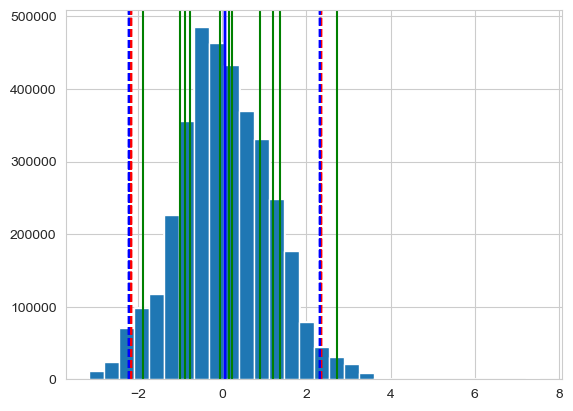

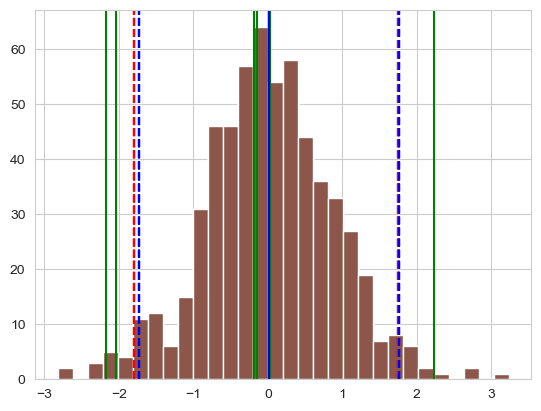

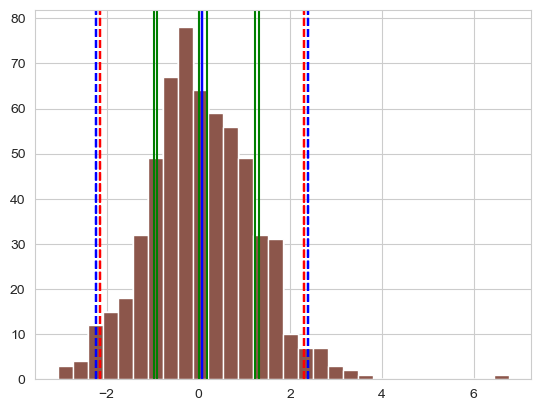

In [39]:

def critical_hist(stat, distribution, alpha=0.05, ax=None):
    ax = plt.figure().add_subplot() if ax is None else ax
    # compute the critical values for alpha=0.05
    lower_percentile = alpha/2 * 100
    lower = np.percentile(distribution, lower_percentile)
    upper = np.percentile(distribution, 100 - lower_percentile)
    mean = np.mean(distribution)
    sd = np.std(distribution)
    ax.hist(distribution, bins=30)
    # draw the vertical lines for the critical values on the subplot
    ax.axvline(lower, color='r', linestyle='--')
    ax.axvline(upper, color='r', linestyle='--')
    ax.axvline(mean, color='b')
    ax.axvline(mean+2*sd, color='b', linestyle='--')
    ax.axvline(mean-2*sd, color='b', linestyle='--')

    # draw vertical line for the stat
    ax.axvline(stat, color='g')

tp_ds = pairwise_stats_results['tp_stats'][:, 1]
ds = np.sort(tp_ds)[::int(len(tp_ds)/10)]
# slope_ds = pairwise_stats_results['slope_stats'][:, 1]
ax = plt.figure().add_subplot()
for d in ds:
    critical_hist(d, all_tp_ds, ax=ax)

slope_ds = pairwise_stats_results['slope_stats'][:, 1]
ds = np.sort(slope_ds)
# slope_ds = pairwise_stats_results['slope_stats'][:, 1]
ax = plt.figure().add_subplot()
for d in ds:
    critical_hist(d, all_slope_ds, ax=ax)

auc_ds = pairwise_stats_results['auc_stats'][:, 1]
ds = np.sort(auc_ds)
# slope_ds = pairwise_stats_results['slope_stats'][:, 1]
ax = plt.figure().add_subplot()
for d in ds:
    critical_hist(d, all_auc_ds, ax=ax)



In [27]:
print(pairwise_stats_results['pairs'])
print(pairwise_stats_results['slope_stats'][:, 1])
pairwise_stats_results['auc_stats'][:, 1]

[('Younger', 'Older'), ('Younger', 'MCI+'), ('Younger', 'MCI-'), ('Older', 'MCI+'), ('Older', 'MCI-'), ('MCI+', 'MCI-')]
[ 0.03133281 -2.04235157 -0.14103706 -2.17661407 -0.18622144  2.22868682]


array([ 1.23768992,  1.3298762 ,  0.19077734,  0.00938829, -0.90573939,
       -0.96109564])

In [34]:
# simulating within-participant data for hierarchical modelling
aoi_col = 'table_minus_moved'
out_dict = {'fit': [], 'slope': [], 'auc': [], 'one_sec': [], 'seven_sec': [], 'participant': [], 'group': []}
fitrep = 54
formula = aoi_col + ' ~ ' + 'time'
groups = ('Younger', 'Older', 'MCI+', 'MCI-')
df['group_participant'] = df['group'] + df['participant'].astype(str)

for g, group in enumerate(groups):
    df_g = df[df.group == group].reset_index(drop=True)
    ppts = df_g.group_participant.unique()
    for p, ppt in enumerate(ppts):
        df_p = df_g[df_g.group_participant == ppt].reset_index(drop=True)
        for rep in range(fitrep):
            mdl = participant_ols(formula, df_p, 'rnorm')
            slope = mdl['slope']
            intercept = mdl['intercept']
            t = df_p.time.to_numpy()
            y = intercept + (slope*t)
            auc = np.sum(y)

            fit = ppt + str(rep)

            dict['slope'].append(slope)
            dict['auc'].append(auc)
            dict['one_sec'].append(y[0])
            dict['seven_sec'].append(y[-1])
            dict['fit'].append(fit)
            dict['participant'].append(ppt)
            dict['group'].append(group)

out_df = pd.DataFrame(dict)
display(out_df.head(10).style)
out_df.to_csv('table_minus_moved_rfit.csv')


,fit,slope,auc,one_sec,seven_sec,participant,group
0,Younger00,-0.000019,186.031619,0.089329,-0.027308,Younger0,Younger
1,Younger01,-0.000005,970.174192,0.177396,0.146050,Younger0,Younger
2,Younger02,-0.000024,618.757084,0.176377,0.029910,Younger0,Younger
3,Younger03,-0.000011,338.569956,0.089272,0.023604,Younger0,Younger
4,Younger04,-0.000017,529.389306,0.140084,0.036409,Younger0,Younger
5,Younger05,-0.000009,938.825629,0.184482,0.128512,Younger0,Younger
6,Younger06,-0.000029,905.795732,0.238958,0.063025,Younger0,Younger
7,Younger07,-0.000009,1262.410387,0.237527,0.183347,Younger0,Younger
8,Younger08,-0.000036,395.547189,0.174853,-0.042982,Younger0,Younger
9,Younger09,-0.000031,713.641199,0.210840,0.027080,Younger0,Younger
